#  **Project: Capstone Project 2– part4**

** *This notebook is part 4 of 4. please follow the sequence **

** Capstone 2 Project -  twitter and yelp user sentiment analysis using NLP**

** Prerequite:- please run notebook 1, 2 and 3 in sequence and that will create the csv file required in data folder.

In [1]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting and visualization:
from IPython.display import display
from textblob import TextBlob
from wordcloud import WordCloud
from credentials import *    # This will allow us to use the keys as variables
from textblob import TextBlob
from wordcloud import STOPWORDS
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import os
import nltk
#nltk.download('stopwords')

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE

#import xgboost as xgb
#import gensim

In [3]:
# Access:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)


def get_tweet_to_csv(filename, hashtaglist):
    csvFile = open(filename, 'a')
    #Use csv Writer
    csvWriter = csv.writer(csvFile)
    
    for tags in hashtaglist:
        for tweet in tweepy.Cursor(api.search, q=tags, count=1000, lang='en').items():
            csvWriter.writerow([tweet.id, tweet.created_at, tweet.text, tweet.source, tweet.favorite_count, tweet.retweet_count])

def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1
            return counter

def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))


In [4]:
def clean_tweets(tweets, remove_stopwords=False, stem=False):
    """
    to clean tweet strings
    tweet: a list of tweet strings
    remove_stop_words: whether to remove stop words
    output: a list of clean tweets
    """
    # 1. Remove HTML
    tweets_text = list(map(lambda x: BeautifulSoup(x, 'html.parser').get_text(), tweets))
    #
    # 2. Remove non-letters
    tweets_text = list(map(lambda x: re.sub("[^a-zA-Z]"," ", x), tweets_text))
    #
    # 3. Convert words to lower case and split them
    words = list(map(lambda x: x.lower().split(), tweets_text))
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        set_of_stopwords = set(stopwords.words("english"))
        meaningful_words = list(map(lambda x: [w for w in x if not w in set_of_stopwords], words))
    
    # 5. Optionally stem the words
    if stem:
        porter_stemmer = PorterStemmer()
        wordnet_lemmatizer = WordNetLemmatizer()
        stemmed_words = list(map(lambda x: [porter_stemmer.stem(w) for w in x], meaningful_words))
        stemmed_words = list(map(lambda x:[wordnet_lemmatizer.lemmatize(w) for w in x], stemmed_words))
    
        # 6. Join the words to a single string
        clean_tweet = map(lambda x: ' '.join(x), stemmed_words)
    else:
        clean_tweet = list(map(lambda x: ' '.join(x), meaningful_words))
    
    return clean_tweet

In [5]:
from textblob import TextBlob
import re

def clean_tweet(text):
    '''
    Utility function to clean the text in a tweet by removing links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def analize_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet using textblob.
    '''
    analysis = TextBlob(clean_tweet(text))
    return analysis.sentiment.polarity


In [6]:
#scrape Yelp public review data for citibike # one time use only.
import requests
import re

rows = []
columns = ['yelp_review']
review_pattern = re.compile(r'"description":(.*?)", "author"')

for n in np.arange(0,16):
    x=n*20
    url = 'https://www.yelp.com/biz/citi-bike-new-york-6?start=%s'% x
    html = requests.get(url).text
    for this_review in re.findall(review_pattern, html):
        row = [this_review]
        rows.append(row)
        df = pd.DataFrame(rows, columns=columns)
    
# Use pandas to write the comma-separated output file
df.to_csv("yelp_review.csv", mode='a',  sep=',', quoting=0)   

In [7]:
#get twitter data

hashtaglist = ['#CitiBike','#citibike', '#bikenyc']

get_tweet_to_csv('citibike.csv',hashtaglist)

In [8]:
#read csv data into dataframe

col_Names = ["id","created", "tweet","source","fav_count","retweet"]
data_tweet = pd.read_csv('citibike.csv', names=col_Names)

data_yelp1 = pd.read_csv('yelp_review.csv')
data_yelp = data_yelp1.drop(['Unnamed: 0'], axis=1)

# We display the first 10 elements of the dataframe:
display(data_tweet.info())
display(data_yelp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 6 columns):
id           996 non-null int64
created      996 non-null object
tweet        996 non-null object
source       996 non-null object
fav_count    996 non-null int64
retweet      996 non-null int64
dtypes: int64(3), object(3)
memory usage: 46.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 1 columns):
yelp_review    641 non-null object
dtypes: object(1)
memory usage: 5.1+ KB


None

In [9]:
# Create new columns in data frame and calculate values.

data_tweet['len'] = data_tweet['tweet'].apply(len)
data_tweet['tweet_date'] = pd.to_datetime(data_tweet['created']).dt.date
    
data_tweet['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_tweet["tweet"]))
data_tweet['hashtag_no'] = list(map(lambda txt: count_occurences("#", txt),data_tweet["tweet"]))
data_tweet['exclamation_no'] = list(map(lambda txt: count_occurences("!", txt),data_tweet["tweet"]))
data_tweet['question_no'] = list(map(lambda txt: count_occurences("?", txt),data_tweet["tweet"]))
data_tweet['mention_no'] = list(map(lambda txt: count_occurences("@", txt),data_tweet["tweet"]))

display(data_tweet.head(10))


data_yelp['len'] = data_yelp['yelp_review'].apply(len)
data_yelp['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_yelp["yelp_review"]))
data_yelp['hashtag_no'] = list(map(lambda txt: count_occurences("#", txt),data_yelp["yelp_review"]))
data_yelp['exclamation_no'] = list(map(lambda txt: count_occurences("!", txt),data_yelp["yelp_review"]))
data_yelp['question_no'] = list(map(lambda txt: count_occurences("?", txt),data_yelp["yelp_review"]))
data_yelp['mention_no'] = list(map(lambda txt: count_occurences("@", txt),data_yelp["yelp_review"]))

display(data_yelp.head(10))

,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no
0,967353562736062465,2018-02-24 11:00:36,An app for CitiBikeNYC #CitiBike on #NYC? Sear...,IFTTT,1,0,138,2018-02-24,60,5,1,2,0
1,966833488052793344,2018-02-23 00:34:01,They see me rollin...\n.\n.\n.\n.\n.\n.\n#unlo...,IFTTT,1,0,126,2018-02-23,52,4,0,0,0
2,966466208978685952,2018-02-22 00:14:34,Is there anything worse than #citibike people ...,Twitter for Android,1,0,134,2018-02-22,33,1,0,1,0
3,966363677392764928,2018-02-21 17:27:09,"Dock less #Citibike #NYC @ New York, New York ...",Instagram,0,0,69,2018-02-21,35,2,0,0,1
4,966357281674858496,2018-02-21 17:01:44,RT @vinnysphotos: Citi-Bike by Union Sq. Park....,Twitter Web Client,0,1,136,2018-02-21,58,3,0,0,1
5,966357060215623680,2018-02-21 17:00:51,RT @navnigarg: We changed every #citibike stat...,Twitter Web Client,0,3,116,2018-02-21,41,2,1,0,1
6,966326936258703360,2018-02-21 15:01:09,The risk of me getting hit by a bike in the ci...,Twitter for iPhone,1,0,140,2018-02-21,43,0,0,0,0
7,966099287041019909,2018-02-20 23:56:33,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,112,2018-02-20,61,6,0,0,0
8,965963956400676864,2018-02-20 14:58:48,So proud that @motivate_co was just listed as ...,Twitter Web Client,7,3,140,2018-02-20,44,0,0,0,2
9,965777345050218496,2018-02-20 02:37:16,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0


,yelp_review,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no
0,"""While Citi Bike can be a convenient way to g...",859,223,0,1,0,0
1,"""Had good experiences over the summer but not...",734,178,0,1,0,0
2,"""Great way to get around Brooklyn (\u0026 NYC...",420,104,0,0,0,0
3,"""I wanted to a rent a bike for sightseeing in...",439,113,0,1,0,0
4,"""I think we need more bikes on everything sta...",112,26,0,0,0,0
5,"""Works like any other city bike rental BUT th...",579,159,0,0,0,0
6,"""A good idea in theory, with terrible executi...",1458,379,0,1,0,0
7,"""This is a review of my annual membership. I ...",1169,276,0,1,0,0
8,"""UPDATE! \nWoke up to find I am being charged...",1028,295,0,12,0,0
9,"""I will never ever rent a bike from this comp...",174,43,0,0,0,0


In [10]:
# Extract the mean of tweet lenghts:

mean = np.mean(data_tweet['len'])
print("The length's average in tweets: {}".format(mean))

# Extract the top tweets with most FAVs and more RTs:

fav_max = np.max(data_tweet['fav_count'])
rt_max  = np.max(data_tweet['retweet'])

fav = data_tweet[data_tweet.fav_count == fav_max].index[0]
rt  = data_tweet[data_tweet.retweet == rt_max].index[0]

# Max FAVs:
print("The tweet with most no of likes is: \n{}".format(data_tweet['tweet'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data_tweet['len'][fav]))

# Max RTs:
print("The tweet with most no of retweets is: \n{}".format(data_tweet['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data_tweet['len'][rt]))

The length's average in tweets: 125.4136546184739
The tweet with most no of likes is: 
The good news is @VistaOutdoorInc's stock is in the toilet right now. That's why they're diversifying from domestic… https://t.co/zmSz64cDdO
Number of likes: 111
140 characters.

The tweet with most no of retweets is: 
The good news is @VistaOutdoorInc's stock is in the toilet right now. That's why they're diversifying from domestic… https://t.co/zmSz64cDdO
Number of retweets: 39
140 characters.



In [11]:
# Create time series for data:

tlen = pd.Series(data=data_tweet['len'].values, index=data_tweet['created'])
tfav = pd.Series(data=data_tweet['fav_count'].values, index=data_tweet['created'])
tret = pd.Series(data=data_tweet['retweet'].values, index=data_tweet['created'])

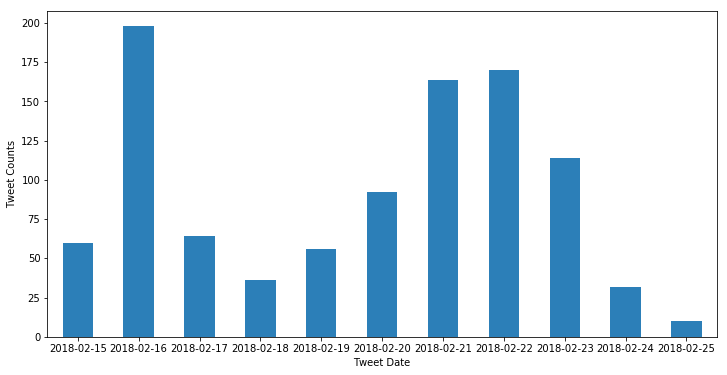

In [12]:
# No of Tweets by Day:

df = data_tweet.groupby(['tweet_date']).agg({'id':'count'})
df.plot(kind = 'bar', figsize=(12, 6), color='#2c7fb8', linewidth=.03, label="No of Tweets", legend=False)
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Tweet Counts')
_ = plt.xlabel('Tweet Date')

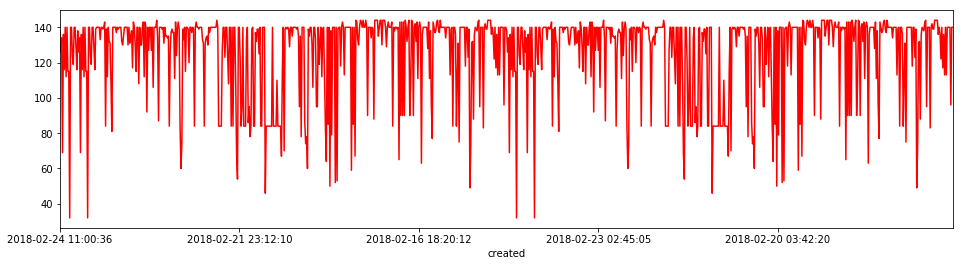

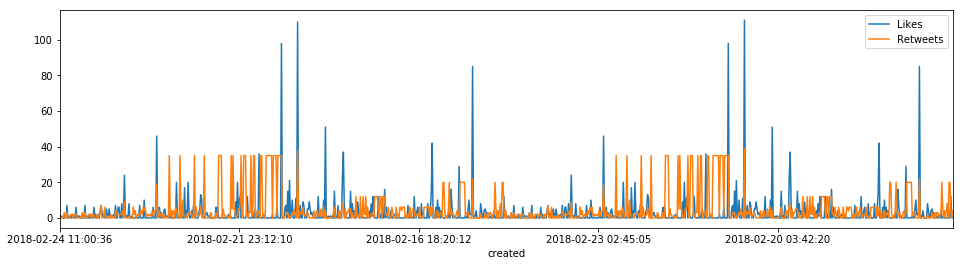

In [13]:
# Tweet Lenghts along time:

tlen.plot(figsize=(16,4), color='r');
plt.show()

# Likes vs retweets visualization:

tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);
plt.show()


In [14]:
# Obtain all possible sources:

sources = []
for source in data_tweet['source']:
    if source not in sources:
        sources.append(source)

# Print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* IFTTT
* Twitter for Android
* Instagram
* Twitter Web Client
* Twitter for iPhone
* Sprout Social
* TweetDeck
* Hootsuite
* Twitter Lite
* Reported_NYC
* AccBiking1
* Tweetbot for iΟS
* Twitter for iPad
* CyclingBot
* Twitter for Mac
* Tweetbot for Mac
* tofubot
* Zapier.com
* Buffer
* Talon Android


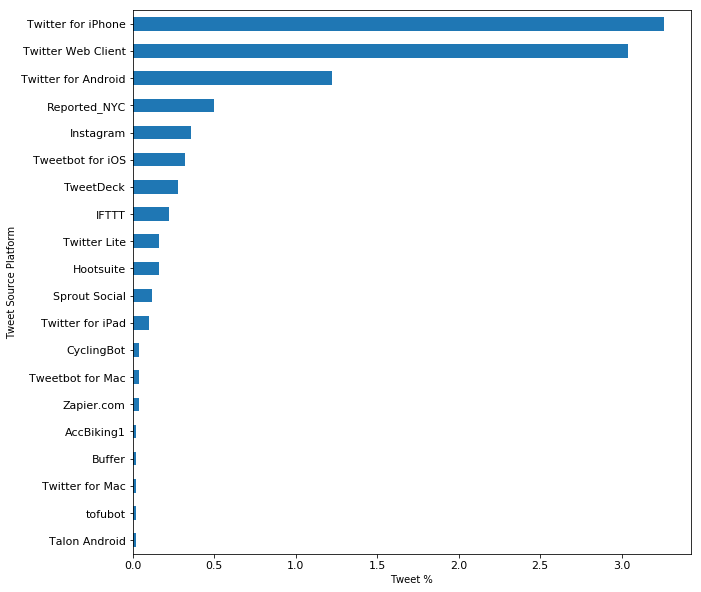

In [15]:
# Create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data_tweet['source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

data = pd.Series(percent, index=sources, name='sources')
data.sort_values(ascending=True, inplace=True)

data.plot.barh(fontsize=11, figsize=(10, 10));
_ = plt.xlabel('Tweet %')
_ = plt.ylabel('Tweet Source Platform')

In [16]:
# Create a column with the result of the analysis:

#df_sub['free_trip'] = np.where(df_sub['tripduration'] <= 2700, 1, 0)
data_tweet['score'] = np.around(np.array([ analize_sentiment(tweet) for tweet in data_tweet['tweet'] ]),3)
data_tweet['SA'] = np.where(data_tweet['score'] > 0, 1, (np.where(data_tweet['score'] < 0, -1, 0)))

# We display the updated dataframe with the new column:
display(data_tweet.head(10))


,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,967353562736062465,2018-02-24 11:00:36,An app for CitiBikeNYC #CitiBike on #NYC? Sear...,IFTTT,1,0,138,2018-02-24,60,5,1,2,0,0.136,1
1,966833488052793344,2018-02-23 00:34:01,They see me rollin...\n.\n.\n.\n.\n.\n.\n#unlo...,IFTTT,1,0,126,2018-02-23,52,4,0,0,0,0.000,0
2,966466208978685952,2018-02-22 00:14:34,Is there anything worse than #citibike people ...,Twitter for Android,1,0,134,2018-02-22,33,1,0,1,0,0.100,1
3,966363677392764928,2018-02-21 17:27:09,"Dock less #Citibike #NYC @ New York, New York ...",Instagram,0,0,69,2018-02-21,35,2,0,0,1,0.035,1
4,966357281674858496,2018-02-21 17:01:44,RT @vinnysphotos: Citi-Bike by Union Sq. Park....,Twitter Web Client,0,1,136,2018-02-21,58,3,0,0,1,0.167,1
5,966357060215623680,2018-02-21 17:00:51,RT @navnigarg: We changed every #citibike stat...,Twitter Web Client,0,3,116,2018-02-21,41,2,1,0,1,0.468,1
6,966326936258703360,2018-02-21 15:01:09,The risk of me getting hit by a bike in the ci...,Twitter for iPhone,1,0,140,2018-02-21,43,0,0,0,0,0.250,1
7,966099287041019909,2018-02-20 23:56:33,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,112,2018-02-20,61,6,0,0,0,0.000,0
8,965963956400676864,2018-02-20 14:58:48,So proud that @motivate_co was just listed as ...,Twitter Web Client,7,3,140,2018-02-20,44,0,0,0,2,0.600,1
9,965777345050218496,2018-02-20 02:37:16,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.000,0


In [17]:
# Create a column with the result of the Yelp's review analysis:

data_yelp['score'] = np.around(np.array([ analize_sentiment(review) for review in data_yelp['yelp_review'] ]),3)
data_yelp['SA'] = np.where(data_yelp['score'] > 0, 1, (np.where(data_yelp['score'] < 0, -1, 0)))
display(data_yelp.head(10))

,yelp_review,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,"""While Citi Bike can be a convenient way to g...",859,223,0,1,0,0,0.172,1
1,"""Had good experiences over the summer but not...",734,178,0,1,0,0,0.064,1
2,"""Great way to get around Brooklyn (\u0026 NYC...",420,104,0,0,0,0,0.126,1
3,"""I wanted to a rent a bike for sightseeing in...",439,113,0,1,0,0,0.076,1
4,"""I think we need more bikes on everything sta...",112,26,0,0,0,0,0.389,1
5,"""Works like any other city bike rental BUT th...",579,159,0,0,0,0,0.002,1
6,"""A good idea in theory, with terrible executi...",1458,379,0,1,0,0,-0.086,-1
7,"""This is a review of my annual membership. I ...",1169,276,0,1,0,0,0.163,1
8,"""UPDATE! \nWoke up to find I am being charged...",1028,295,0,12,0,0,0.231,1
9,"""I will never ever rent a bike from this comp...",174,43,0,0,0,0,0.133,1


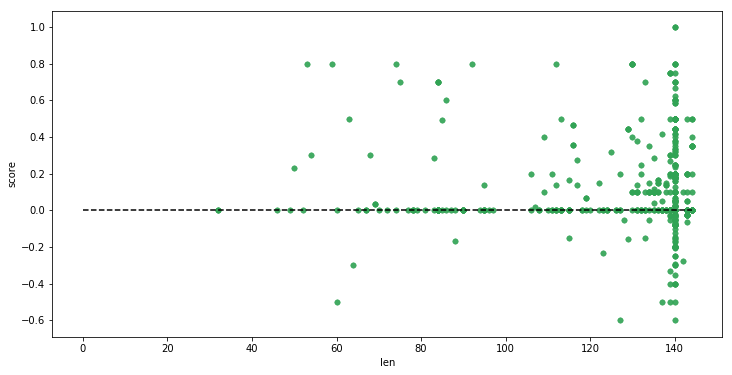

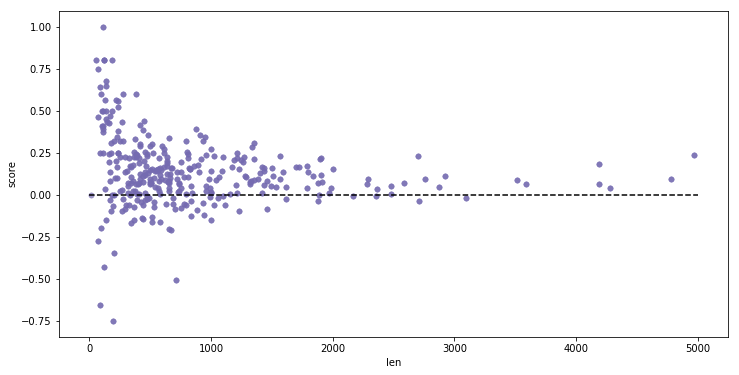

In [18]:
# Plot sentiment score along with length of tweet / review

data_tweet.plot.scatter(x='len', y='score', figsize=(12, 6), color='#31a354', alpha=.7, linewidth=.3, s=30);
plt.plot([0, 144], [0, 0], 'k--', color="Black")
plt.show()


data_yelp.plot.scatter(x='len', y='score', figsize=(12, 6), color='#756bb1', alpha=.7, linewidth=.3, s=30);
plt.plot([0, 5000], [0, 0], 'k--', color="Black")
plt.show()

In [19]:
# Construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] < 0]

In [20]:
# Print percentages:

pos_tweet_count = len(pos_tweets)*100/len(data_tweet['tweet'])
neu_tweet_count = len(neu_tweets)*100/len(data_tweet['tweet'])
neg_tweet_count = len(neg_tweets)*100/len(data_tweet['tweet'])
                                    
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data_tweet['tweet'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data_tweet['tweet'])))
print("Percentage for negative tweets: {}%".format(len(neg_tweets)*100/len(data_tweet['tweet'])))


Percentage of positive tweets: 42.16867469879518%
Percentage of neutral tweets: 44.17670682730924%
Percentage for negative tweets: 13.654618473895582%


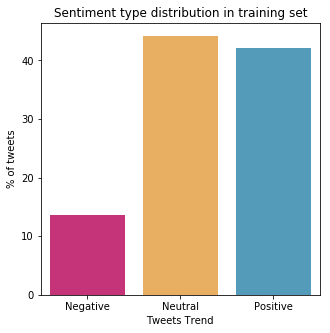

In [21]:
# Plot the tweet count based on the sentiment outcome

colors = ['#dd1c77','#feb24c','#43a2ca']
x_bar=["Negative","Neutral","Positive"]
y_bar=[neg_tweet_count, neu_tweet_count, pos_tweet_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% of tweets', xlabel='Tweets Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

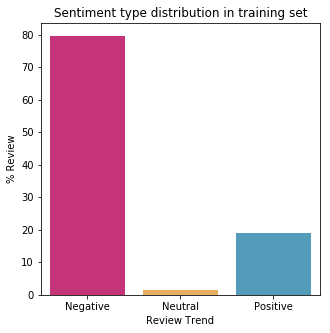

In [22]:
# Construct lists with classified reviews:

pos_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] > 0]
neu_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] == 0]
neg_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] < 0]


pos_review_count = len(pos_review)*100/len(data_yelp['yelp_review'])
neu_review_count = len(neu_review)*100/len(data_yelp['yelp_review'])
neg_review_count = len(neg_review)*100/len(data_yelp['yelp_review'])

# Plot the review count based on the sentiment outcome

colors = ['#dd1c77','#feb24c','#43a2ca']
x_bar=["Negative","Neutral","Positive"]
y_bar=[pos_review_count, neu_review_count, neg_review_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% Review', xlabel='Review Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

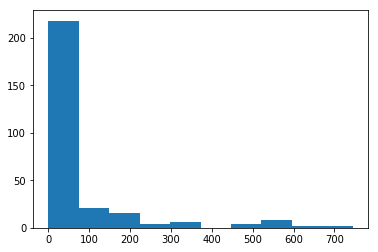

In [23]:
# Removing stopwords and punctuation for proper bigram creation

all_words3 = ', '.join(data_tweet.tweet)

# Combine all tweets and Split the script into lines: lines

for tweet in [all_words3] :
    
    lines = tweet.split('\n')

    # Replace all script lines for speaker
    pattern = "[A-Z]{2,}(\s)?(#\d)?([A-Z]{2,})?:"
    lines = [re.sub(pattern, '', l) for l in lines]

    # Tokenize each line: tokenized_lines
    tokenized_tweets = [regexp_tokenize(s, '\w+') for s in lines]

    # Make a frequency list of lengths: line_num_words
    line_num_words = [len(t_line) for t_line in tokenized_tweets]

    # Plot a histogram of the line lengths
    plt.hist(line_num_words)

# Show the plot
plt.show()

In [24]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('citibike_data.xls', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
data_tweet.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()


## Now lets cleanup the twitter data

### Data Cleaning and Text Preprocessing

<div class="span25 alert alert-info">
Removing HTML Markup with The BeautifulSoup Package.

Even though the review text is not in HTML, let's use the package BeautifulSoup.
<br> </br>
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
<br> </br>
Convert words into lower case and tonkenize, i.e. split the text into individual words.

<br></br>

The reviews are now list of word strings.

</div>

In [25]:
# cleanup tweet using The BeautifulSoup Package.

data_tweet['tweet_bs'] = data_tweet['tweet'].apply(lambda x: BeautifulSoup(x, 'html.parser'))
data_tweet.tweet_bs[0].get_text()

data_tweet['tweet_letters_only'] = data_tweet['tweet_bs'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.get_text()))
data_tweet['tweet_letters_only'][0]

data_tweet['tweet_words'] = data_tweet['tweet_letters_only'].apply(lambda x: x.lower().split())
data_tweet['tweet_words'][0]

['an',
 'app',
 'for',
 'citibikenyc',
 'citibike',
 'on',
 'nyc',
 'searching',
 'newyork',
 'bikes',
 'citibike',
 'there',
 's',
 'a',
 'new',
 'kid',
 'on',
 'the',
 'block',
 'try',
 'https',
 't',
 'co',
 'bgzjw',
 'phwc']

In [26]:

train = pd.read_excel('citibike_data.xls', header=0, delimiter="\t", quoting=3)
print('Dimension of Labeled Training Data: {}.'.format(train.shape))
print('There are {0} samples and {1} variables in the training data.'.format(train.shape[0], train.shape[1]))

display(train.head())
print(train.tweet[0])

Dimension of Labeled Training Data: (996, 15).
There are 996 samples and 15 variables in the training data.


,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,967353562736062464,2018-02-24 11:00:36,An app for CitiBikeNYC #CitiBike on #NYC? Sear...,IFTTT,1,0,138,2018-02-24,60,5,1,2,0,0.136,1
1,966833488052793344,2018-02-23 00:34:01,They see me rollin...\n.\n.\n.\n.\n.\n.\n#unlo...,IFTTT,1,0,126,2018-02-23,52,4,0,0,0,0.000,0
2,966466208978685952,2018-02-22 00:14:34,Is there anything worse than #citibike people ...,Twitter for Android,1,0,134,2018-02-22,33,1,0,1,0,0.100,1
3,966363677392764928,2018-02-21 17:27:09,"Dock less #Citibike #NYC @ New York, New York ...",Instagram,0,0,69,2018-02-21,35,2,0,0,1,0.035,1
4,966357281674858496,2018-02-21 17:01:44,RT @vinnysphotos: Citi-Bike by Union Sq. Park....,Twitter Web Client,0,1,136,2018-02-21,58,3,0,0,1,0.167,1


An app for CitiBikeNYC #CitiBike on #NYC? Searching #NewYork #bikes #CitiBike? There's a new kid on the block! Try https://t.co/BGzJW9PHWC


<div class="span25 alert alert-info">
Remove stop words with ntlk and as the final step, join the list of words into a single string.
</div>

In [27]:
# Removing stopwords and punctuation for proper word cloud creation after all cleanups


set_of_stopwords = set(stopwords.words("english"))
data_tweet['tweet_meaningful_words'] = data_tweet['tweet_words'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

num_removed = len(data_tweet['tweet_words'][0]) - len(data_tweet['tweet_meaningful_words'][0])
print('For the first Tweet, the number of stop words removed is {0}.'.format(num_removed))

data_tweet['tweet_cleaned'] = data_tweet['tweet_meaningful_words'].apply(lambda x: ' '.join(x)) # comment if using stemming

For the first Tweet, the number of stop words removed is 9.


<div class="span25 alert alert-info">
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
<br> </br>
The reviews are now strings of letters only.
</div>

In [28]:
#drop extra columns

data_tweet.drop(['tweet', 'tweet_bs', 'tweet_letters_only', 'tweet_words', 'tweet_meaningful_words'], 
           axis=1, inplace=True)
display(data_tweet.head())
print(data_tweet['tweet_cleaned'][0])

,id,created,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA,tweet_cleaned
0,967353562736062465,2018-02-24 11:00:36,IFTTT,1,0,138,2018-02-24,60,5,1,2,0,0.136,1,app citibikenyc citibike nyc searching newyork...
1,966833488052793344,2018-02-23 00:34:01,IFTTT,1,0,126,2018-02-23,52,4,0,0,0,0.000,0,see rollin unlockmiami citibike bikeride south...
2,966466208978685952,2018-02-22 00:14:34,Twitter for Android,1,0,134,2018-02-22,33,1,0,1,0,0.100,1,anything worse citibike people line bikes stra...
3,966363677392764928,2018-02-21 17:27:09,Instagram,0,0,69,2018-02-21,35,2,0,0,1,0.035,1,dock less citibike nyc new york new york https...
4,966357281674858496,2018-02-21 17:01:44,Twitter Web Client,0,1,136,2018-02-21,58,3,0,0,1,0.167,1,rt vinnysphotos citi bike union sq park using ...


app citibikenyc citibike nyc searching newyork bikes citibike new kid block try https co bgzjw phwc


In [29]:
# Removing stopwords and punctuation for proper bigram creation after all cleanups

clean_tweets = ', '.join(data_tweet.tweet_cleaned)
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram


stopwords1 = ['https', 'http', '.co', 'co', 'rt', 'dot']
for stopword in stopwords1:
    clean_tweets = clean_tweets.replace(stopword,'')
    
words_bigram = bigram(clean_tweets)

Single Cloud:


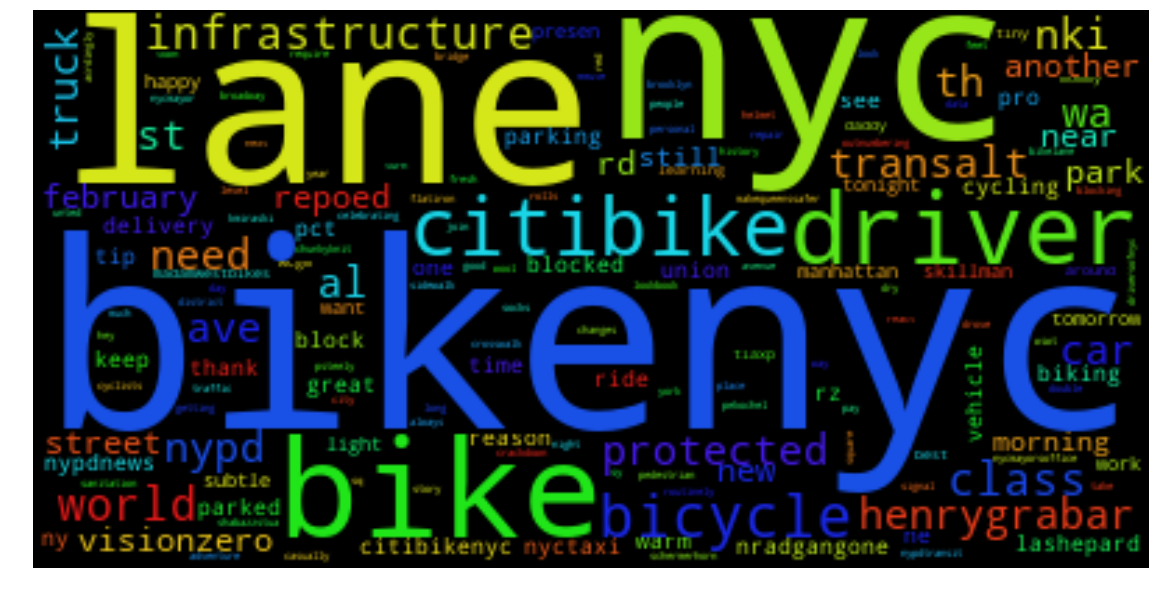

Bigrams:


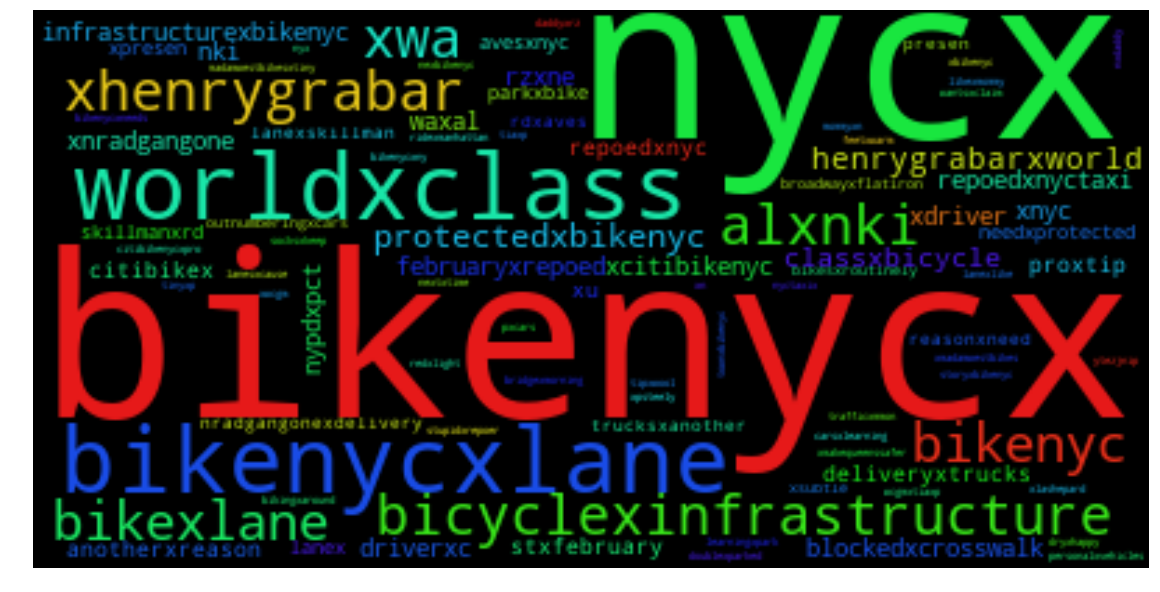

In [30]:
# Single Cloud

wordcloud = WordCloud().generate(clean_tweets)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud

wordcloud_bigrams = WordCloud().generate(words_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

              Word  Frequency       Word Encoded
0          bikenyc        688         b'bikenyc'
1              nyc        262             b'nyc'
2             lane        192            b'lane'
3             bike        170            b'bike'
4         citibike         82        b'citibike'
5          bicycle         80         b'bicycle'
6   infrastructure         76  b'infrastructure'
7            class         74           b'class'
8            world         72           b'world'
9      henrygrabar         70     b'henrygrabar'
10              wa         70              b'wa'
11              al         70              b'al'
12             nki         70             b'nki'
13       protected         68       b'protected'
14              th         64              b'th'
15              st         64              b'st'
16          driver         62          b'driver'
17            nypd         62            b'nypd'
18        transalt         60        b'transalt'
19        february  

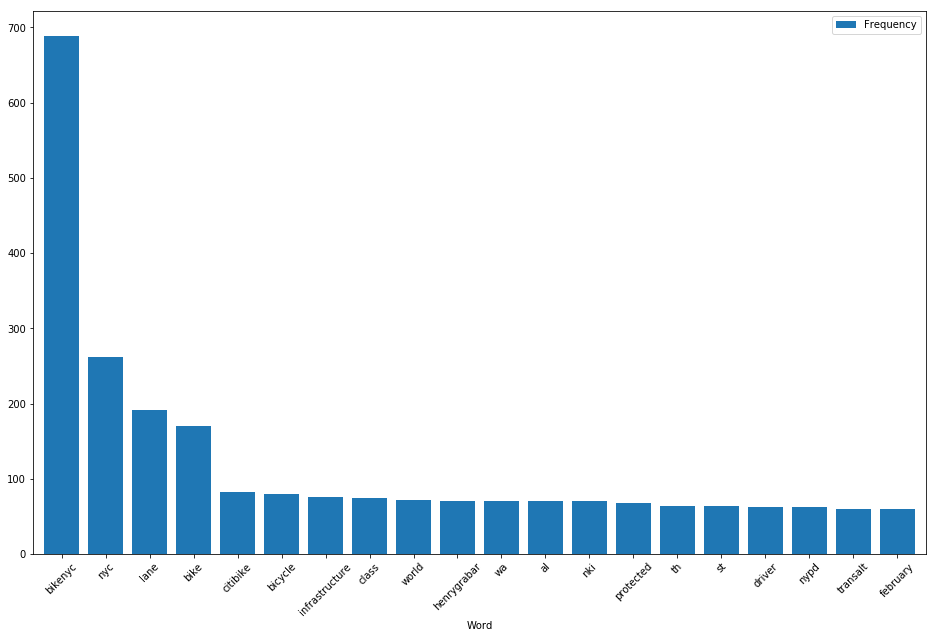

In [31]:
#plot most common words in tweet

import unicodedata

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt','RT','https', 'http', '.co', 'co','dot']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (data_tweet.tweet_cleaned
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
#words_data.drop('Word', axis=1).to_csv('word-frequencies.csv')
print(words_data.head(20))

# plot
words_data[:20].plot(x = 'Word', kind = 'bar', figsize=(16,10), width=0.8)
_ = plt.xticks(rotation=45)


<div class="span25 alert alert-info">
Now the training data is ready for using Bag of Words Analysis.
<br></br>
<br></br>
Initialize the CountVectorizer object, which is scikit-learn's bag of words tool. CountVectorizer converts a collection of text documents to a matrix of token counts.
</div>


## Creating Features from a Bag of Words (Using scikit-learn)¶


In [32]:
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, tokenizer=None, stop_words=None, max_features=5000)

In [33]:
# Split train and test data
# Numpy arrays are easy to work with, so convert the result to an array

data_features = list(data_tweet['tweet_cleaned'].values)
data_target = list(data_tweet['SA'].values)

F_train, F_test, T_train, T_test = train_test_split(data_features, data_target, test_size = 0.3, random_state=42)


In [34]:
# fit vectorizer to create train and test set by bag of words 

messages_bow = vectorizer.fit_transform(F_train)
test_bow = vectorizer.transform(F_test)

print ('Shape of Sparse Matrix: ', messages_bow.shape)
print ('Amount of Non-Zero occurences: ', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz /
                             (messages_bow.shape[0] * messages_bow.shape[1])))
print(messages_bow.shape)
print(test_bow.shape)

Shape of Sparse Matrix:  (697, 1766)
Amount of Non-Zero occurences:  9552
sparsity: 0.78%
(697, 1766)
(299, 1766)


In [35]:
# Fit using TfidfTransformer to create train and test set by bag of words 

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.fit_transform(messages_bow)
print(messages_tfidf.shape)

tfidf_transformer1 = TfidfTransformer().fit(test_bow)
test_tfidf = tfidf_transformer1.fit_transform(test_bow)
print(test_tfidf.shape)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(messages_tfidf, T_train)

predicted = clf.predict(test_tfidf)

print(np.mean(predicted == T_test))

(697, 1766)
(299, 1766)
0.903010033444816


## Random Forest Classifer
Let's try a random forest with the features we just created.

In [36]:
# Initialize a Random Forest classifier with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as labels
# This may take a few minutes to run
rf_clf.fit(messages_tfidf, T_train)
result = rf_clf.predict(test_tfidf)

print(np.mean(result == T_test))

0.8795986622073578


In [37]:
print("confusion matrix: ",confusion_matrix(T_test, result))
print("classification report: ", classification_report(T_test, result))


confusion matrix:  [[ 38   5   4]
 [  0 118   2]
 [  0  25 107]]
classification report:               precision    recall  f1-score   support

         -1       1.00      0.81      0.89        47
          0       0.80      0.98      0.88       120
          1       0.95      0.81      0.87       132

avg / total       0.90      0.88      0.88       299



Model has a Precision value of .90 and recall of 0.88

High precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [55]:
tweet_train, tweet_test, label_train, label_test = \
train_test_split(list(data_tweet['tweet_cleaned'].values), list(data_tweet['SA'].values), test_size=0.2)

print (len(tweet_train), len(tweet_test), len(tweet_train) + len(tweet_test))

796 200 996


###### Pipeline to try and evaluate different model and parameter combinations :-

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from pprint import pprint
from time import time
import logging

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', tol=None)),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (500, 2000, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.001, 0.0001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 100),
}


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a main block / " __main__" protected block
    # find the best parameters for both the feature extraction and the classifier
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    
    pprint(parameters)
    t0 = time()
    #grid_search.fit(X_new, y_new)
    grid_search.fit(tweet_train, label_train)
    

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.001, 0.0001),
 'clf__n_iter': (10, 50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (500, 2000, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  1.6min finished


In [57]:
print("done in %0.3fs" % (time() - t0))
print("-----")
print("Best score: %0.3f" % grid_search.best_score_)
print("Best Model:",  grid_search.best_estimator_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


done in 98.487s
-----
Best score: 0.920
Best Model: Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...cnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])
Best parameters set:
	clf__alpha: 0.0001
	clf__n_iter: 10
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__max_features: 2000
	vect__ngram_range: (1, 1)


In [58]:
predicted = grid_search.predict(tweet_test)
print(np.mean(predicted == label_test))   

print("confusion matrix: ",confusion_matrix(label_test, predicted))
print("classification report: ", classification_report(label_test, predicted))

0.96
confusion matrix:  [[24  0  2]
 [ 0 89  2]
 [ 2  2 79]]
classification report:               precision    recall  f1-score   support

         -1       0.92      0.92      0.92        26
          0       0.98      0.98      0.98        91
          1       0.95      0.95      0.95        83

avg / total       0.96      0.96      0.96       200



In [59]:
print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(label_train, grid_search.predict(tweet_train)),
    mean_absolute_error(label_test, predicted)))
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(label_train, grid_search.predict(tweet_train)),
    mean_squared_error(label_test, predicted)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(label_train, grid_search.predict(tweet_train)),
    r2_score(label_test, predicted))))

MAE train: 0.000, test: 0.060
MSE train: 0.000, test: 0.100
R^2 train: 1.000, test: 0.784


R^2 value is 94% for train data and only 72% for test data. MSE is also very high for test data.

we need to further try various parameter to tune this model

In [60]:
# Models to try
models = {
    'RF': RandomForestClassifier( oob_score = True ),
    'LR' : LogisticRegression(),
}

# Parameters to try (this is not an exahustive GridSearch)

params = {
    'RF': {'n_estimators' : [1000, 2000],
            'max_depth': [6, 12],
            'min_samples_leaf': [1, 3],
            'max_features': [1.0, 0.3]},
    'LR' : {'penalty' : ['l1', 'l2'],
            'class_weight' : ['balanced']},
}

In [61]:
class EstimatorSelectionHelper:
    
    """
    A helper class for running parameter grid search across different models. 
    It takes two dictionaries. The first contains the models to be scored. 
    The second contains the parameters for each model
    """
    
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False): 
        """
        fit(X,y) method runs a parameter grid search with cross validation for each model
        and for the given training data. If scoring=None, the score method of the estimator is used.
        """
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs 
            
    
    
    def score_summary(self, sort_by='mean_score'):
        """
        After calling fit(X,y), the score_summary() method returns a df with a summary of the scores
        """
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                }

            return pd.Series(dict(list( params.items()) + list(d.items() ))) #sum up two dicts
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                for k in self.keys
                for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

In [62]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(messages_tfidf, T_train, n_jobs=-1)


Running GridSearchCV for RF.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.8min finished


Running GridSearchCV for LR.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


In [63]:
helper.score_summary()


,estimator,min_score,mean_score,max_score,std_score,class_weight,max_depth,max_features,min_samples_leaf,n_estimators,penalty
17,LR,0.875536,0.882368,0.887446,0.00501746,balanced,NaN,NaN,NaN,NaN,l2
9,RF,0.763948,0.767584,0.770563,0.00273987,NaN,12,1,1,2000,NaN
8,RF,0.761905,0.766128,0.76824,0.00298662,NaN,12,1,1,1000,NaN
12,RF,0.725322,0.750342,0.781116,0.0231383,NaN,12,0.3,1,1000,NaN
13,RF,0.729614,0.75033,0.781116,0.0221987,NaN,12,0.3,1,2000,NaN
10,RF,0.729614,0.741746,0.755365,0.0105652,NaN,12,1,3,1000,NaN
11,RF,0.725322,0.737442,0.751073,0.010567,NaN,12,1,3,2000,NaN
14,RF,0.699571,0.723086,0.751073,0.0212621,NaN,12,0.3,3,1000,NaN
15,RF,0.699571,0.721656,0.746781,0.0193931,NaN,12,0.3,3,2000,NaN
0,RF,0.695279,0.718856,0.74026,0.0184275,NaN,6,1,1,1000,NaN


Logistic regression and random forest classifer comes out as best model with the given set of paraemters. we will take this model and parameter set as baseline to evaluate the optimal output.

In [64]:
reg = RandomForestClassifier(n_estimators=1000, n_jobs=2, random_state=42, min_samples_leaf=1, max_features = 1) 

reg.fit(messages_tfidf, T_train)

y_pred = reg.predict(test_tfidf)


In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

accuracy = accuracy_score(T_test, y_pred)

print(accuracy)
print(np.mean(result == T_test))

cv_scores = cross_val_score(reg, test_tfidf, T_test, cv=10)

# Print the 5-fold cross-validation scores

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

0.9230769230769231
0.8795986622073578
Average 5-Fold CV Score: 0.8099888765294772


In [66]:
logreg = LogisticRegression()

# Setup the hyperparameter grid
c_space = np.logspace(0, 3, 7)
param_grid = {'C': c_space, 'penalty': ['l2'], 'class_weight':['balanced']}

# Instantiate the logistic regression classifier with Grid Search
logreg_cv = GridSearchCV(logreg, param_grid, cv=3)

# Fit the classifier to the training data
logreg_cv.fit(messages_tfidf, T_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# Predict the target of the test set
target_pred = logreg_cv.predict(test_tfidf)
train_pred = logreg_cv.predict(messages_tfidf)

Tuned Logistic Regression Parameters: {'C': 3.1622776601683795, 'class_weight': 'balanced', 'penalty': 'l2'}
Best score is 0.9096126255380201


In [67]:
cv_scores_lr = cross_val_score(logreg_cv, test_tfidf, T_test, cv=10)

# Print the 5-fold cross-validation scores

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_lr)))

Average 5-Fold CV Score: 0.8198813496477568


45% tweets are with positive sentiment, 42% with neutral and 13% tweets with negative sentiment
78% yelp reviews are having negative sentiment

The combined sentiment is 39% positive and is towards negative due to high negative Yelp reviews.

NLP machine learning model used Logistic regression classifier and accuracy was 81%